In [1]:
import torch 
from torch import optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

import matplotlib.pyplot as plt

from model.model import SentenceEncoder, SentenceDecoder, ImageEncoder, cnnTransforms
from dataset import VisDialDataset
from utils.token import Lang

from VQA.model import VQAModel
from VQA.utils import collate_fn, setData, trainSentence, predit, beamPredit

jsonFile = "/home/ball/dataset/mscoco/visdialog/visdial_1.0_val.json"
cocoDir = "/home/ball/dataset/mscoco/"
langFile = "dataset/lang.pkl"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [2]:
lang = Lang.load(langFile)
dataset = VisDialDataset(dialFile = jsonFile,
                         cocoDir = cocoDir, 
#                          sentTransform = torch.LongTensor,
#                          imgTransform = cnnTransforms,
#                          convertSentence = lang.sentenceToVector
                        )

Load lang model: dataset/lang.pkl. Word size: 43974


Preparing image paths with image_ids: 133351it [00:00, 374273.46it/s]


In [3]:
loader = torch.utils.data.DataLoader(dataset, 
                                     batch_size=5, 
                                     shuffle=True, 
                                     num_workers=4, 
                                     collate_fn=collate_fn)
it = iter(loader)

Process Process-2:
Process Process-3:
Process Process-1:
Process Process-4:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ball/anaconda3/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/ball/anaconda3/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/ball/anaconda3/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/ball/anaconda3/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/ball/anaconda3/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ball/anaconda3/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ball/anaconda3/lib/python3.5/multiprocessing/process.py", 

In [4]:
data = it.next()
images_t, questions_t, answers_t = setData(data, lang, DEVICE)

TypeError: Traceback (most recent call last):
  File "/home/ball/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 106, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/ball/Documents/Visdial/VQA/utils.py", line 36, in collate_fn
    images = torch.stack(images)
TypeError: expected Tensor as element 0 in argument 0, but got list


In [5]:
model = torch.load("VQA/models/fullQA/VQAmodel.5.pth").to(DEVICE).eval()

RuntimeError: CUDA error: out of memory

In [14]:
question = "how many people"
predit(model, DEVICE, lang, cnnTransforms(data["image"]), lang.sentenceToVector(question))[0]

'1'

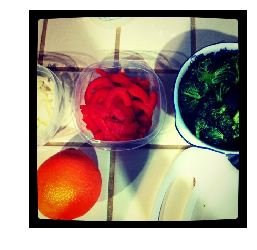

Question:is it there with spoons
Answer	:no | no
GT	:no spoons

Question:white plates
Answer	:yes | yes
GT	:no

Question:are the veggies green
Answer	:yes | yes
GT	:yes

Question:is there a banana
Answer	:no | no
GT	:no banana, just a orange

Question:is there a grape
Answer	:no | no
GT	:don't think so, very blurry picture

Question:count the fruits for me
Answer	:i think so i think so i think so i think so i think so i think so i think | i think so i think so i think so i think so i think so i think so i think
GT	:i can t, they are in a bowl, i can t count just 1 full orange

Question:is there a stove nearby
Answer	:no | no
GT	:no

Question:is there a human in the photo
Answer	:no | no
GT	:no people, just some bowls and a orange

Question:is it sunny
Answer	:yes | yes
GT	:yes, sunshine over the bowls

Question:is there a sink nearby
Answer	:no | no
GT	:no



In [13]:
data = dataset[62]
answers_p = []
for question, answer in zip(data["questions"], data["answers"]):
    ansString, probs = beamPredit(model, DEVICE, lang, cnnTransforms(data["image"]), lang.sentenceToVector(question), 5)
    ansString_, probs = beamPredit(model, DEVICE, lang, cnnTransforms(data["image"]), lang.sentenceToVector(question), 1)

    #     _ansString, probs = predit(model, DEVICE, lang, cnnTransforms(ano), lang.sentenceToVector(question))

    answers_p.append({
        "question": question,
        "answer": ansString[0],
        "answer_b1": ansString_[0],
        "GT": answer
    })
plt.axis('off')
plt.imshow(data["image"])
plt.show()
for r in answers_p:
    print("Question:{}\nAnswer\t:{}\nGT\t:{}\n".format(r["question"], r["answer"]+" | "+r["answer_b1"], r["GT"]))

In [48]:
from tqdm import tqdm
import numpy as np
allans = []
stock = []
for i in tqdm(range(1000, 1010)):
    data = dataset[i]
    answers_p = []
    for question, answers in zip(data["questions"], data["answers"]):
        ansString, probs = predit(model, DEVICE, lang, cnnTransforms(data["image"]), lang.sentenceToVector(question))
        _ansString, probs = predit(model, DEVICE, lang, cnnTransforms(dataset[0]["image"]), lang.sentenceToVector(question))
        
        answers_p.append(1 if ansString == _ansString else 0)
        if not ansString == _ansString:
            stock.append([i, ansString, _ansString])
#         answers_p.append(len(ansString.split(" ")))
    allans.append(answers_p)

100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


In [49]:
import numpy as np
np.array(allans).mean()

0.97999999999999998

In [50]:
np.array(allans).mean()

0.97999999999999998

In [51]:
stock

[[1001, 'no', 'yes'], [1009, 'no', 'yes']]

In [31]:
allans

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]